In [1]:
from   hmmlearn.hmm import GaussianHMM
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
DATA = '../data'
sp = pd.read_csv(f'{DATA}/sp1950.csv')
nyse = pd.read_csv(f'{DATA}/nya1965.csv')
nas = pd.read_csv(f'{DATA}/nasdaq1965.csv')
wil = pd.read_csv(f'{DATA}/wilshire1990.csv')

In [3]:
sp.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1950-01-03,16.66,16.66,16.66,16.66,16.66,1260000
1,1950-01-04,16.85,16.85,16.85,16.85,16.85,1890000
2,1950-01-05,16.93,16.93,16.93,16.93,16.93,2550000
3,1950-01-06,16.98,16.98,16.98,16.98,16.98,2010000
4,1950-01-09,17.08,17.08,17.08,17.08,17.08,2520000


In [4]:
x = sp['Adj Close'].to_numpy()
np.append([np.nan], x[1:] / x[:-1])

array([       nan, 1.01140459, 1.00474777, ..., 1.00945076, 1.01988326,
       1.02474226])

In [5]:
def get_daily_changes(series):
    x = series.to_numpy()
    return np.append([1], x[1:] / x[:-1])

In [6]:
def prep_df(df):
    df.index = pd.to_datetime(df.Date)
    df['daily'] = get_daily_changes(df['Adj Close'])
    return df[['Adj Close', 'daily']]

In [7]:
[sp, nyse, nas, wil] = [prep_df(df) for df in [sp, nyse, nas, wil]]
sp.head()

,Adj Close,daily
Date,,
1950-01-03,16.66,1.000000
1950-01-04,16.85,1.011405
1950-01-05,16.93,1.004748
1950-01-06,16.98,1.002953
1950-01-09,17.08,1.005889


In [8]:
def find_best_mod(daily, n_states=[6, 7, 8], max_iter=1000):
    daily = np.reshape(daily.values, [-1, 1])
    best_logprob = -np.inf
    best_mod = None
    for states in n_states:
        mod = GaussianHMM(
            n_components=states, n_iter=max_iter
        ).fit(daily)
        logprob = mod.score(daily)
        if logprob > best_logprob:
            print(f'New best - States: {states}')
            best_logprob = logprob
            best_mod = mod
    return best_mod

In [9]:
def get_preds(daily, mod):
    daily = np.reshape(daily.values, [-1, 1])
    states = mod.predict(daily)
    means = np.squeeze(mod.means_)
    sds = np.squeeze(np.sqrt(mod.covars_))
    preds = np.array([means[state] for state in states])
    ses = np.array([1.96 * sds[state] for state in states])
    return preds, ses, means, states[-1]

In [10]:
def plot_mod(df, preds, ses):
    #preds, ses = get_preds(sp.daily, sp_mod)
    plt.plot(df.daily, label='daily')
    plt.plot(df.index, preds, label='preds')
    plt.legend()

    plt.figure()
    plt.plot(df.daily, label='daily')
    plt.axhline(y=1, color='k')
    plt.plot(
        df.index, preds, label='preds', color='orange', linewidth=3)
    plt.plot(df.index, preds + ses, color='orange', linestyle='-.')
    plt.plot(df.index, preds - ses, color='orange', linestyle='-.')
    plt.ylim([0.95, 1.05]);
    plt.xlim([df.index[-500], df.index[-1]])

    plt.figure()
    plt.plot(df['Adj Close'])
    plt.xlim([df.index[-500], df.index[-1]])
    sub = df.iloc[-500:, :]
    plt.ylim(
        0.95 * sub['Adj Close'].min(), 1.05 * sub['Adj Close'].max());

In [11]:
def get_expected_val(mod, current_state, means):
    return np.dot(mod.transmat_[current_state, :], means)

## S&P

New best - States: 5
New best - States: 6
0.998823527348098


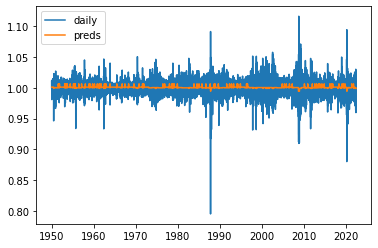

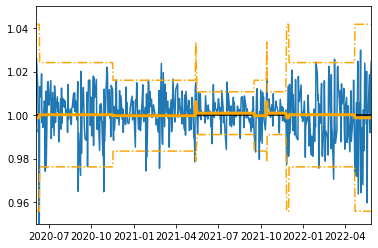

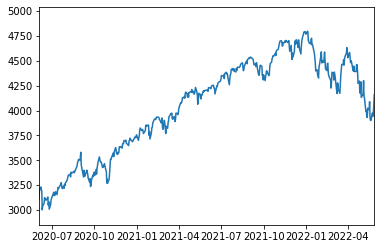

In [12]:
sp_mod = find_best_mod(sp.daily, n_states=[5, 6, 7])
sp_preds, sp_ses, sp_means, sp_current = get_preds(sp.daily, sp_mod)
plot_mod(sp, sp_preds, sp_ses)
sp_exp = get_expected_val(sp_mod, sp_current, sp_means)
print(sp_exp)

## NYSE

New best - States: 6
New best - States: 7
1.0000285791463954


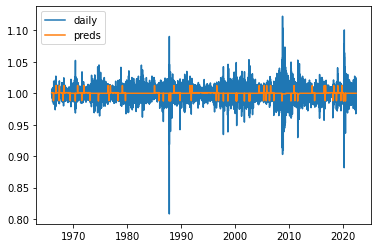

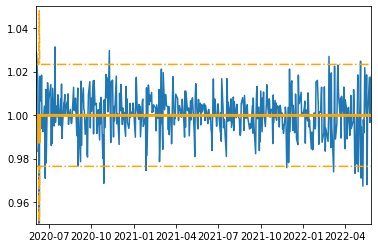

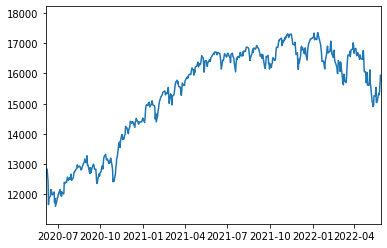

In [13]:
nyse_mod = find_best_mod(nyse.daily, n_states=[6, 7, 8])
nyse_preds, nyse_ses, nyse_means, nyse_current = get_preds(
    nyse.daily, nyse_mod)
plot_mod(nyse, nyse_preds, nyse_ses)
nyse_exp = get_expected_val(nyse_mod, nyse_current, nyse_means)
print(nyse_exp)

## Nasdaq

New best - States: 6
New best - States: 7
1.0005121617804231


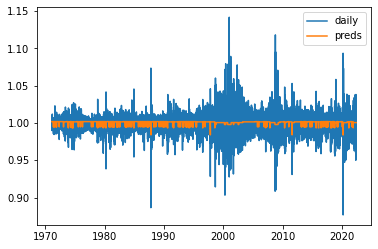

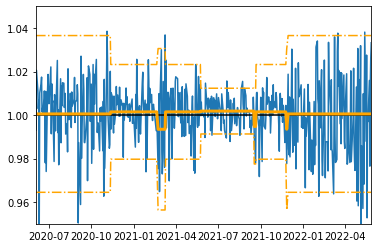

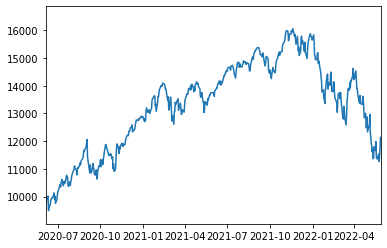

In [14]:
nas_mod = find_best_mod(nas.daily, n_states=[6, 7, 8])
nas_preds, nas_ses, nas_means, nas_current = get_preds(
    nas.daily, nas_mod)
plot_mod(nas, nas_preds, nas_ses)
nas_exp = get_expected_val(nas_mod, nas_current, nas_means)
print(nas_exp)

## Wilshire

New best - States: 6
New best - States: 8
0.9981280014153077


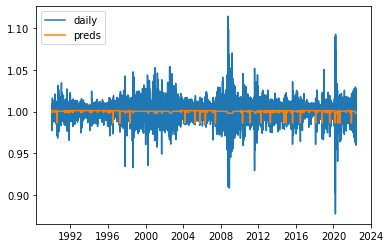

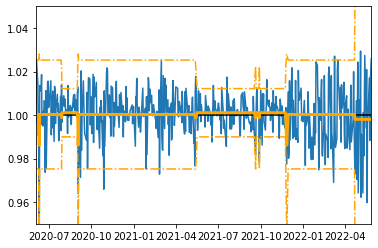

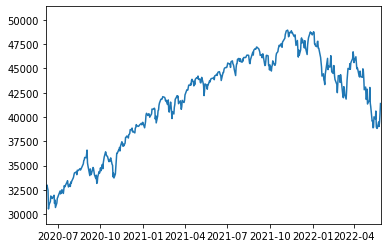

In [15]:
wil_mod = find_best_mod(wil.daily, n_states=[6, 7, 8])
wil_preds, wil_ses, wil_means, wil_current = get_preds(
    wil.daily, wil_mod)
plot_mod(wil, wil_preds, wil_ses)
wil_exp = get_expected_val(wil_mod, wil_current, wil_means)
print(wil_exp)

In [16]:
exp = (sp_exp + nyse_exp + nas_exp + wil_exp) / 4
exp

0.9993730674225562